In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy  as np

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print(train.shape)
print(test.shape)

(2931, 3)
(1743, 2)


3    1376
1     624
4     583
2     348
Name: jobflag, dtype: int64


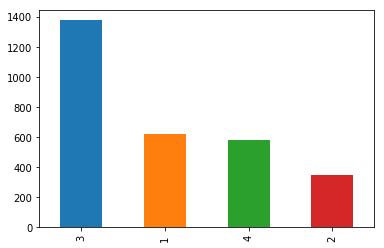

In [4]:
print(train['jobflag'].value_counts())
train['jobflag'].value_counts().plot(kind = 'bar')

Text(0,0.5,'word count')

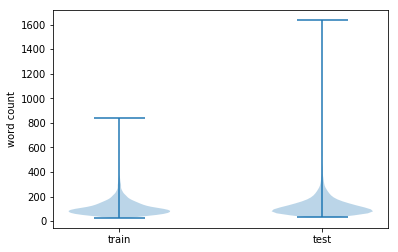

In [5]:
train_length = train['description'].str.len()
test_length = test['description'].str.len()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([train_length, test_length])
ax.set_xticks([1, 2])
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('word count')

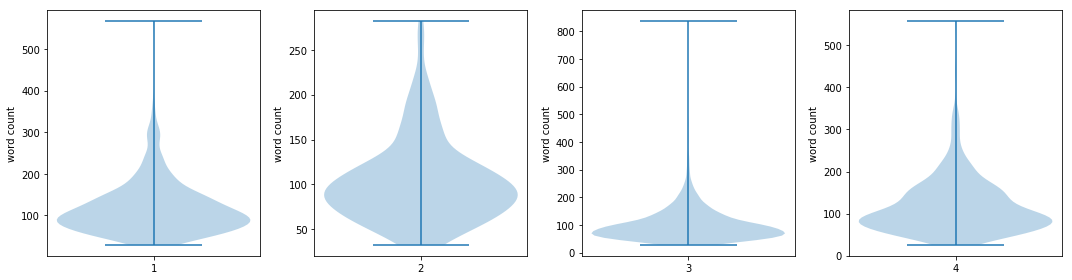

In [6]:
fig = plt.figure(figsize = (15, 4))
for flag in [1, 2, 3, 4]:
    train_length_flag = train[train['jobflag'] == flag]['description'].str.len()
    ax = fig.add_subplot(1, 4, flag)
    ax.violinplot(train_length_flag)
    ax.set_xticks([1])
    ax.set_xticklabels([flag])
    ax.set_ylabel('word count')
plt.tight_layout()

In [7]:
#学習用データと評価用データを結合する (両データに対し一括で前処理を行うため)
combined = train.append(test, ignore_index=True, sort=True)

In [8]:
#以下の手順でdescriptionデータのクリーニングを行う.
# アルファベット以外の文字をスペースに置き換える
# 単語長が3文字以下のものは削除する
# ステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）

import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

combined_cleaned = combined.copy()
combined_cleaned['description'] = cleaning(combined['description'])

In [9]:
# クリーニング結果の確認
print('#original\n', combined['description'][0])
print("-----")
print('#cleaned\n', combined_cleaned['description'][0])

#original
 Executes and writes portions of testing plans, protocols, and documentation for assigned portion of application; identifies and debugs issues with code and suggests changes or improvements.
-----
#cleaned
 execut write portion test plan protocol document assign portion applic identifi debug issu with code suggest chang improv


In [33]:
#bag of words(文章中の単語の登場回数をカウントし, 特徴量化する手法)を用いて、descriptionをベクトル化する

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=5, max_features=2000, stop_words='english')
bow = bow_vectorizer.fit_transform(combined_cleaned['description'])
print(bow.shape)

(4674, 1057)


In [34]:
#学習用データを分割して, 投稿前の精度検証を行う

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import time

delimit_num = train.shape[0]
train_bow = bow[:delimit_num, :]
test_bow = bow[delimit_num:, :]

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_trans = TfidfTransformer()
train_tfidf = tfidf_trans.fit_transform(train_bow)

x_tfidf_train, x_tfidf_valid, y_tfidf_train, y_tfidf_valid = train_test_split(train_tfidf, train['jobflag'], test_size=0.3, random_state=0)

In [35]:
params ={
    "C":np.arange(0.1,2,0.05),
    "kernel":["linear"]
}
grid = GridSearchCV(SVC(),params,cv=6,n_jobs=6)
start = time.time()
grid.fit(x_tfidf_train,y_tfidf_train)
print("time",time.time()-start)

time 26.934964418411255


In [36]:
grid.best_params_

{'C': 0.8500000000000002, 'kernel': 'linear'}

In [37]:
pred = grid.predict(x_tfidf_train)
print(classification_report(y_tfidf_train,pred))
pred = grid.predict(x_tfidf_valid)
print(classification_report(y_tfidf_valid,pred))

             precision    recall  f1-score   support

          1       0.77      0.77      0.77       441
          2       0.89      0.40      0.55       251
          3       0.75      0.94      0.84       953
          4       0.86      0.64      0.73       406

avg / total       0.79      0.78      0.77      2051

             precision    recall  f1-score   support

          1       0.63      0.54      0.58       183
          2       0.54      0.23      0.32        97
          3       0.67      0.87      0.76       423
          4       0.60      0.43      0.50       177

avg / total       0.63      0.64      0.62       880



             precision    recall  f1-score   support

          1      0.631     0.541     0.582       183
          2      0.537     0.227     0.319        97
          3      0.667     0.875     0.757       423
          4      0.598     0.429     0.500       177

avg / total      0.631     0.644     0.621       880



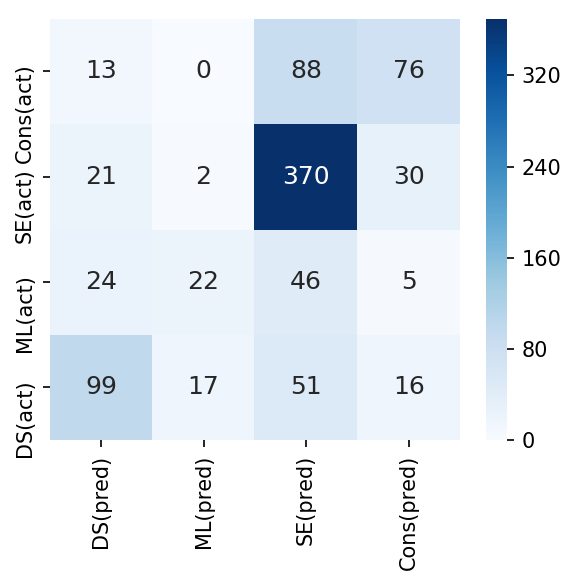

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(y_tfidf_valid, pred, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(y_tfidf_valid, pred, labels=labels, digits=3))